# Set Dependencies and Configuations

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from huggingface_hub import PyTorchModelHubMixin
import pickle
import json
import os

DATA_PATH = "/content/drive/MyDrive/Dataset/data.csv"

# --- CONFIGURATION ---
CONFIG = {
    "SEQ_LEN": 30,
    "BATCH_SIZE": 64,
    "HIDDEN_DIM": 64,
    "LAYERS": 2,
    "DROPOUT": 0.4,
    "EPOCHS": 50,
    "PATIENCE": 7,
    "LR": 1e-3,
    "WD": 1e-5,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- UTILITIES ---
class EarlyStopping:
    def __init__(self, patience=7, path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

# --- MODEL ---
class FloodLSTM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :]).squeeze()


def create_tensors(df):
    cutoff = pd.Timestamp("2024-01-01")
    train_df = df[df['date'] < cutoff].copy()
    test_df = df[df['date'] >= cutoff].copy()

    # Export Test Set for Optuna
    test_df.to_csv("test_set.csv", index=False)

    features = ['water', 'total_report', 'API_30d', 'API_60d', 'API_90d', 'month_sin', 'month_cos', 'latitude', 'longitude']
    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    test_df[features] = scaler.transform(test_df[features])

    with open("scaler.pkl", "wb") as f: pickle.dump(scaler, f)

    def _slide(sub_df):
        X, y = [], []
        for _, g in sub_df.groupby('subdistrict'):
            v = g[features].values
            t = g['target'].values
            if len(v) <= CONFIG["SEQ_LEN"]: continue
            for i in range(len(v) - CONFIG["SEQ_LEN"]):
                X.append(v[i : i+CONFIG["SEQ_LEN"]])
                y.append(t[i+CONFIG["SEQ_LEN"]])
        return np.array(X), np.array(y)

    X_tr, y_tr = _slide(train_df)
    X_te, y_te = _slide(test_df)
    pos_weight = (len(y_tr) - sum(y_tr)) / (sum(y_tr) + 1e-5)
    return (X_tr, y_tr), (X_te, y_te), pos_weight, len(features)

# --- EXECUTION ---
if __name__ == "__main__":
    print(">>> 🏋️ Phase 1: Training Started...")
    # LOAD YOUR DATA HERE
    df_full = pd.read_csv(DATA_PATH)
    df_clean = process_data(df_full)
    (X_tr, y_tr), (X_te, y_te), p_weight, input_dim = create_tensors(df_clean)

    # Dataset Wrapper
    class DS(Dataset):
        def __init__(self, X, y): self.X, self.y = torch.FloatTensor(X), torch.FloatTensor(y)
        def __len__(self): return len(self.X)
        def __getitem__(self, i): return self.X[i], self.y[i]

    tr_loader = DataLoader(DS(X_tr, y_tr), batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
    te_loader = DataLoader(DS(X_te, y_te), batch_size=CONFIG["BATCH_SIZE"], shuffle=False)

    model = FloodLSTM(input_dim, CONFIG["HIDDEN_DIM"], CONFIG["LAYERS"], CONFIG["DROPOUT"]).to(CONFIG["DEVICE"])
    opt = torch.optim.Adam(model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WD"])
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(p_weight).to(CONFIG["DEVICE"]))
    stop = EarlyStopping(patience=CONFIG["PATIENCE"])

    for ep in range(CONFIG["EPOCHS"]):
        model.train()
        t_loss = 0
        for X, y in tr_loader:
            X, y = X.to(CONFIG["DEVICE"]), y.to(CONFIG["DEVICE"])
            opt.zero_grad()
            loss = crit(model(X), y)
            loss.backward()
            opt.step()
            t_loss += loss.item()

        model.eval()
        v_loss = 0
        with torch.no_grad():
            for X, y in te_loader:
                X, y = X.to(CONFIG["DEVICE"]), y.to(CONFIG["DEVICE"])
                v_loss += crit(model(X), y).item()

        print(f"Epoch {ep+1:02d}: Train {t_loss/len(tr_loader):.4f} | Val {v_loss/len(te_loader):.4f}")
        stop(v_loss/len(te_loader), model)
        if stop.early_stop: break

    # Save
    config = {"input_dim": input_dim, "hidden_dim": CONFIG["HIDDEN_DIM"], "num_layers": CONFIG["LAYERS"], "dropout": CONFIG["DROPOUT"]}
    with open("config.json", "w") as f: json.dump(config, f)
    torch.save(model.state_dict(), "pytorch_model.bin")
    print("✅ Phase 1 Complete.")

>>> 🏋️ Phase 1: Training Started...
>>> [ETL] Processing Data...
Epoch 01: Train 0.9576 | Val 1.1436
Epoch 02: Train 0.9302 | Val 1.1375
Epoch 03: Train 0.9211 | Val 1.1444
Epoch 04: Train 0.9138 | Val 1.1230
Epoch 05: Train 0.9100 | Val 1.1223
Epoch 06: Train 0.9058 | Val 1.1340
Epoch 07: Train 0.9020 | Val 1.1274
Epoch 08: Train 0.8968 | Val 1.1328
Epoch 09: Train 0.8958 | Val 1.1341
Epoch 10: Train 0.8922 | Val 1.1310
Epoch 11: Train 0.8903 | Val 1.1283
Epoch 12: Train 0.8884 | Val 1.1416
✅ Phase 1 Complete.


# Optuna Tuning Thresould

In [70]:
import optuna
import pandas as pd
import numpy as np
import torch
import pickle
import json
from sklearn.metrics import fbeta_score
# from train_final import FloodLSTM, process_data # Import dependencies

def run_tuning():
    print(">>> 🧠 Phase 2: Optuna Tuning...")
    device = torch.device("cpu")

    # Load Artifacts
    with open("config.json", "r") as f: conf = json.load(f)
    with open("scaler.pkl", "rb") as f: scaler = pickle.load(f)
    model = FloodLSTM(conf["input_dim"], conf["hidden_dim"], conf["num_layers"], conf["dropout"])
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.eval()

    # Load Test Data
    df = pd.read_csv("test_set.csv")
    df = process_data(df)

    features = ['water', 'total_report', 'API_30d', 'API_60d', 'API_90d', 'month_sin', 'month_cos', 'latitude', 'longitude']
    SEQ_LEN = 30

    # Cache Predictions
    print("    ⚡ Caching Predictions...")
    y_true, y_probs, months = [], [], []

    for sub, g in df.groupby('subdistrict'):
        if len(g) <= SEQ_LEN: continue

        # SCALE DATAFRAME FIRST (Fixes Warning)
        g_scaled = g.copy()
        g_scaled[features] = scaler.transform(g[features])
        v_scaled = g_scaled[features].values

        t = g['target'].values
        m = g['month_timestamp'].values

        for i in range(len(g) - SEQ_LEN):
            X_ts = torch.FloatTensor(v_scaled[i : i+SEQ_LEN]).unsqueeze(0)
            with torch.no_grad():
                prob = torch.sigmoid(model(X_ts)).item()
            y_probs.append(prob)
            y_true.append(t[i+SEQ_LEN])
            months.append(m[i+SEQ_LEN])

    y_true, y_probs, months = np.array(y_true), np.array(y_probs), np.array(months)

    def objective(trial):
        th_wet = trial.suggest_float("wet", 0.2, 0.6)
        th_dry = trial.suggest_float("dry", 0.5, 0.9)
        thresholds = np.where((months >= 5) & (months <= 10), th_wet, th_dry)
        preds = (y_probs > thresholds).astype(int)
        return fbeta_score(y_true, preds, beta=2)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    with open("thresholds.json", "w") as f: json.dump(study.best_params, f)
    print("✅ Phase 2 Complete. Thresholds saved.")

if __name__ == "__main__":
    run_tuning()

>>> 🧠 Phase 2: Optuna Tuning...
    ⚡ Caching Predictions...


[I 2025-11-21 11:42:43,276] A new study created in memory with name: no-name-ef96e567-ea9b-44fe-9829-a55c9372b981
[I 2025-11-21 11:42:43,283] Trial 0 finished with value: 0.45708159201802945 and parameters: {'wet': 0.4728692029258648, 'dry': 0.8045684176891525}. Best is trial 0 with value: 0.45708159201802945.
[I 2025-11-21 11:42:43,289] Trial 1 finished with value: 0.4791515528379452 and parameters: {'wet': 0.2568473080977852, 'dry': 0.6366826647693159}. Best is trial 1 with value: 0.4791515528379452.
[I 2025-11-21 11:42:43,295] Trial 2 finished with value: 0.4317568360521066 and parameters: {'wet': 0.528178799292574, 'dry': 0.7188705459250597}. Best is trial 1 with value: 0.4791515528379452.
[I 2025-11-21 11:42:43,300] Trial 3 finished with value: 0.4200711333269249 and parameters: {'wet': 0.544398271768108, 'dry': 0.7167505355332657}. Best is trial 1 with value: 0.4791515528379452.
[I 2025-11-21 11:42:43,305] Trial 4 finished with value: 0.4801826641392383 and parameters: {'wet': 0.

✅ Phase 2 Complete. Thresholds saved.


# Validation Part

>>> 🧪 Starting Backtest Validation on /content/flood_data_test.csv...
    ☁️ Syncing artifacts...
    ✅ Found pre-calculated 'target' column.
    ⚡ Running Inference...

📊 FINAL BACKTEST REPORT (2024 Data)
              precision    recall  f1-score   support

    No Flood       0.92      0.51      0.66     41808
       Flood       0.21      0.76      0.33      7255

    accuracy                           0.54     49063
   macro avg       0.57      0.63      0.49     49063
weighted avg       0.82      0.54      0.61     49063

Confusion Matrix:
   True Negatives (Safe):  21221
   False Positives (Alarm): 20587
   False Negatives (Missed): 1762  <-- Must be low
   True Positives (Caught):  5493

🛡️ Safety Score (F2): 0.4985


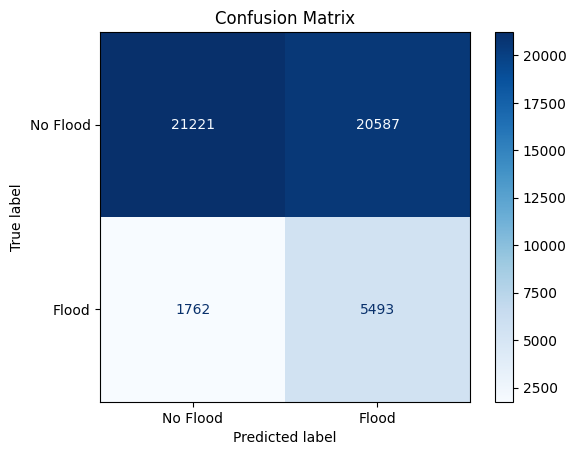

In [102]:
import pandas as pd
import torch
import torch.nn as nn
import pickle
import json
import numpy as np # Import numpy
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --- 1. MODEL CLASS (Must match training) ---
class FloodLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :]).squeeze()

# --- 2. VALIDATION ENGINE ---
def run_validation(test_csv_path="/content/flood_data_test.csv", repo_id="sirasira/flood-lstm-v1"):
    print(f">>> 🧪 Starting Backtest Validation on {test_csv_path}...")

    # A. Download Resources
    print("    ☁️ Syncing artifacts...")
    scaler = pickle.load(open(hf_hub_download(repo_id, "scaler.pkl"), "rb"))
    config = json.load(open(hf_hub_download(repo_id, "config.json"), "r"))
    weights = torch.load(hf_hub_download(repo_id, "pytorch_model.bin"), map_location="cpu")
    thresh_config = json.load(open(hf_hub_download(repo_id, "thresholds.json"), "r"))

    model = FloodLSTM(config["input_dim"], config["hidden_dim"], config["num_layers"], config["dropout"])
    model.load_state_dict(weights)
    model.eval()

    # B. Load Data
    df = pd.read_csv(test_csv_path)

    # --- SENIOR FIX: Handle "Processed" vs "Raw" Data ---
    # 1. Date Processing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    else:
        # Reconstruct from timestamp parts if 'date' doesn't exist
        df['date'] = pd.to_datetime({'year': df['year_timestamp'], 'month': df['month_timestamp'], 'day': df['days_timestamp']})

    df = df.sort_values(['subdistrict', 'date']).reset_index(drop=True)

    # 2. Feature Engineering (Idempotent - safe to run twice)
    # If API columns exist, this just overwrites them (safe). If missing, it creates them.
    for w in [30, 60, 90]:
        col = f'API_{w}d'
        df[col] = df.groupby('subdistrict')['water'].transform(lambda x: x.rolling(w, min_periods=1).mean()).bfill()

    df['month_timestamp'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month_timestamp'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_timestamp'] / 12)

    # 3. TARGET RESOLUTION (The Fix)
    if 'target' in df.columns:
        print("    ✅ Found pre-calculated 'target' column.")
        # Ensure it's int
        df['target'] = df['target'].astype(int)
    elif 'number_of_report_flood' in df.columns:
        print("    ⚙️ Calculating 'target' from 'number_of_report_flood'...")
        df['target'] = (df['number_of_report_flood'] > 0).astype(int)
    else:
        print("❌ CRITICAL ERROR: No Ground Truth found.")
        print(f"   Columns found: {list(df.columns)}")
        print("   Please verify your input CSV contains 'target' or 'number_of_report_flood'.")
        return

    # C. Prediction Loop
    features = ['water', 'total_report', 'API_30d', 'API_60d', 'API_90d', 'month_sin', 'month_cos', 'latitude', 'longitude']
    SEQ_LEN = 30

    y_true_all = []
    y_pred_all = []

    print("    ⚡ Running Inference...")
    for sub, g in df.groupby('subdistrict'):
        if len(g) <= SEQ_LEN: continue

        # Scale
        g_scaled = g.copy()
        g_scaled[features] = scaler.transform(g[features])
        vals = g_scaled[features].values
        targets = g['target'].values
        months = g['month_timestamp'].values

        for i in range(len(g) - SEQ_LEN):
            # Input Tensor
            X = torch.FloatTensor(vals[i : i+SEQ_LEN]).unsqueeze(0)

            # Model Prediction
            with torch.no_grad():
                prob = torch.sigmoid(model(X)).item()

            # Dynamic Threshold Application
            # We look at the MONTH of the prediction target (i + SEQ_LEN)
            target_month = months[i+SEQ_LEN]
            is_wet = 5 <= target_month <= 10
            limit = thresh_config["wet"] if is_wet else thresh_config["dry"]

            pred_label = 1 if prob > limit else 0

            y_pred_all.append(pred_label)
            y_true_all.append(targets[i+SEQ_LEN])

    # D. Generate Report
    print("\n" + "="*60)
    print("📊 FINAL BACKTEST REPORT (2024 Data)")
    print("="*60)

    if len(y_true_all) == 0:
        print("⚠️ No predictions made. Check sequence length vs data size.")
        return

    print(classification_report(y_true_all, y_pred_all, target_names=["No Flood", "Flood"]))

    cm = confusion_matrix(y_true_all, y_pred_all)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix:")
    print(f"   True Negatives (Safe):  {tn}")
    print(f"   False Positives (Alarm): {fp}")
    print(f"   False Negatives (Missed): {fn}  <-- Must be low")
    print(f"   True Positives (Caught):  {tp}")

    f2 = fbeta_score(y_true_all, y_pred_all, beta=2)
    print(f"\n🛡️ Safety Score (F2): {f2:.4f}")
    print("="*60)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Flood", "Flood"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


if __name__ == "__main__":
    run_validation()

In [89]:
from huggingface_hub import HfApi
from google.colab import userdata
import os

def deploy():
    print(">>> ☁️ Phase 3: Deploying...")
    api = HfApi()
    repo_id = "sirasira/flood-lstm-v1"
    token = userdata.get('HF_TOKEN')

    files = ["pytorch_model.bin", "config.json", "scaler.pkl", "thresholds.json"]

    for f in files:
        if os.path.exists(f):
            print(f"   Uploading {f}...")
            api.upload_file(path_or_fileobj=f, path_in_repo=f, repo_id=repo_id, token=token)
        else:
            print(f"❌ Missing {f}. Did you run Phases 1 & 2?")

    print("✅ Phase 3 Complete. Production Ready.")

if __name__ == "__main__":
    deploy()

>>> ☁️ Phase 3: Deploying...
   Uploading pytorch_model.bin...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  pytorch_model.bin           : 100%|##########|  213kB /  213kB            

No files have been modified since last commit. Skipping to prevent empty commit.


   Uploading config.json...


No files have been modified since last commit. Skipping to prevent empty commit.


   Uploading scaler.pkl...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  scaler.pkl                  : 100%|##########|   853B /   853B            

No files have been modified since last commit. Skipping to prevent empty commit.


   Uploading thresholds.json...


No files have been modified since last commit. Skipping to prevent empty commit.


✅ Phase 3 Complete. Production Ready.


# Prediction

In [73]:
import pandas as pd
import torch
import torch.nn as nn
import pickle
import json
import os
from huggingface_hub import hf_hub_download

# ==========================================
# 1. MODEL ARCHITECTURE (Must match training exactly)
# ==========================================
class FloodLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :]).squeeze()

# ==========================================
# 2. PREDICTION ENGINE
# ==========================================
def run_forecast(csv_path, repo_id="sirasira/flood-lstm-v1", burn_in=90):
    print(f">>> 🚀 Starting Forecast on {csv_path}...")

    # --- A. Download Resources ---
    print("    ☁️ Syncing with Hugging Face Hub...")
    try:
        files = ["scaler.pkl", "config.json", "pytorch_model.bin", "thresholds.json"]
        paths = {}
        for f in files:
            paths[f] = hf_hub_download(repo_id=repo_id, filename=f)
    except Exception as e:
        return f"❌ Error downloading resources: {e}"

    # --- B. Load Artifacts ---
    with open(paths["scaler.pkl"], "rb") as f: scaler = pickle.load(f)
    with open(paths["config.json"], "r") as f: conf = json.load(f)
    with open(paths["thresholds.json"], "r") as f: thresh = json.load(f)

    # Load Model
    device = torch.device("cpu")
    model = FloodLSTM(conf["input_dim"], conf["hidden_dim"], conf["num_layers"], conf["dropout"])
    model.load_state_dict(torch.load(paths["pytorch_model.bin"], map_location=device))
    model.eval()

    # --- C. Load & ETL Data ---
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        return f"❌ Error: Input file '{csv_path}' not found."

    # Date & Sort
    df['date'] = pd.to_datetime({'year': df['year_timestamp'], 'month': df['month_timestamp'], 'day': df['days_timestamp']})
    df = df.sort_values(['subdistrict', 'date']).reset_index(drop=True)

    # Physics Features (API)
    print("    ⚙️ calculating Physics Features...")
    for w in [30, 60, 90]:
        col = f'API_{w}d'
        df[col] = df.groupby('subdistrict')['water'].transform(lambda x: x.rolling(w, min_periods=1).mean()).bfill()

    # Seasonality Features
    df['month_sin'] = np.sin(2 * np.pi * df['month_timestamp'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_timestamp'] / 12)

    # --- D. Prediction Loop ---
    features = ['water', 'total_report', 'API_30d', 'API_60d', 'API_90d', 'month_sin', 'month_cos', 'latitude', 'longitude']
    SEQ_LEN = 30
    results = []

    print("    🔮 Running Inference...")
    for sub, g in df.groupby('subdistrict'):
        if len(g) <= burn_in:
            print(f"    ⚠️ Skipping {sub}: Not enough data for burn-in ({len(g)} rows).")
            continue

        # Scale Group
        g_scaled = g.copy()
        g_scaled[features] = scaler.transform(g[features])
        vals = g_scaled[features].values
        dates = g['date'].values
        months = g['month_timestamp'].values

        # Start predicting AFTER the burn-in period
        for i in range(burn_in, len(g)):
            seq_start = i - SEQ_LEN
            if seq_start < 0: continue

            # Create Tensor
            X_ts = torch.FloatTensor(vals[seq_start:i]).unsqueeze(0).to(device)

            # Forward Pass
            with torch.no_grad():
                prob = torch.sigmoid(model(X_ts)).item()

            # Apply Dynamic Threshold
            current_month = months[i]
            is_wet = 5 <= current_month <= 10
            limit = thresh["wet"] if is_wet else thresh["dry"]

            results.append({
                "date": str(pd.Timestamp(dates[i]).date()),
                "location": sub,
                "risk_score": f"{prob:.2%}",
                "status": "🚨 FLOOD" if prob > limit else "✅ Safe",
                "threshold_used": f"{limit:.3f}"
            })

    return pd.DataFrame(results)

# ==========================================
# 3. EXECUTION BLOCK
# ==========================================
if __name__ == "__main__":
    # Change this to your input filename
    INPUT_FILE = "/content/flood_data_test.csv"
    OUTPUT_FILE = "2024_forecast.csv"

    df_result = run_forecast(INPUT_FILE)

    if isinstance(df_result, pd.DataFrame):
        if not df_result.empty:
            print(f"\n>>> ✅ Forecast Complete! Saving to {OUTPUT_FILE}")
            print(df_result.tail()) # Show last 5 days
            df_result.to_csv(OUTPUT_FILE, index=False)
        else:
            print(">>> ⚠️ No predictions made. Check input data length.")
    else:
        print(df_result) # Print Error Message

>>> 🚀 Starting Forecast on /content/flood_data_test.csv...
    ☁️ Syncing with Hugging Face Hub...
    ⚙️ calculating Physics Features...
    🔮 Running Inference...
    ⚠️ Skipping ทับช้าง: Not enough data for burn-in (12 rows).
    ⚠️ Skipping พญาไท: Not enough data for burn-in (11 rows).
    ⚠️ Skipping พระโขนงใต้: Not enough data for burn-in (5 rows).
    ⚠️ Skipping รัชดาภิเษก: Not enough data for burn-in (5 rows).
    ⚠️ Skipping ราษฎร์พัฒนา: Not enough data for burn-in (5 rows).

>>> ✅ Forecast Complete! Saving to 2024_forecast.csv
             date location risk_score  status threshold_used
38798  2024-12-24   โคกแฝด     34.60%  ✅ Safe          0.502
38799  2024-12-26   โคกแฝด     33.74%  ✅ Safe          0.502
38800  2024-12-28   โคกแฝด     32.16%  ✅ Safe          0.502
38801  2024-12-29   โคกแฝด     30.47%  ✅ Safe          0.502
38802  2024-12-31   โคกแฝด     29.38%  ✅ Safe          0.502


# Visualization

>>> 🛠️ Installing Thai Fonts...


/tmp/ipython-input-3075306992.py:121: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3075306992.py:121: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3075306992.py:121: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3075306992.py:121: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3075306992.py:121: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:1

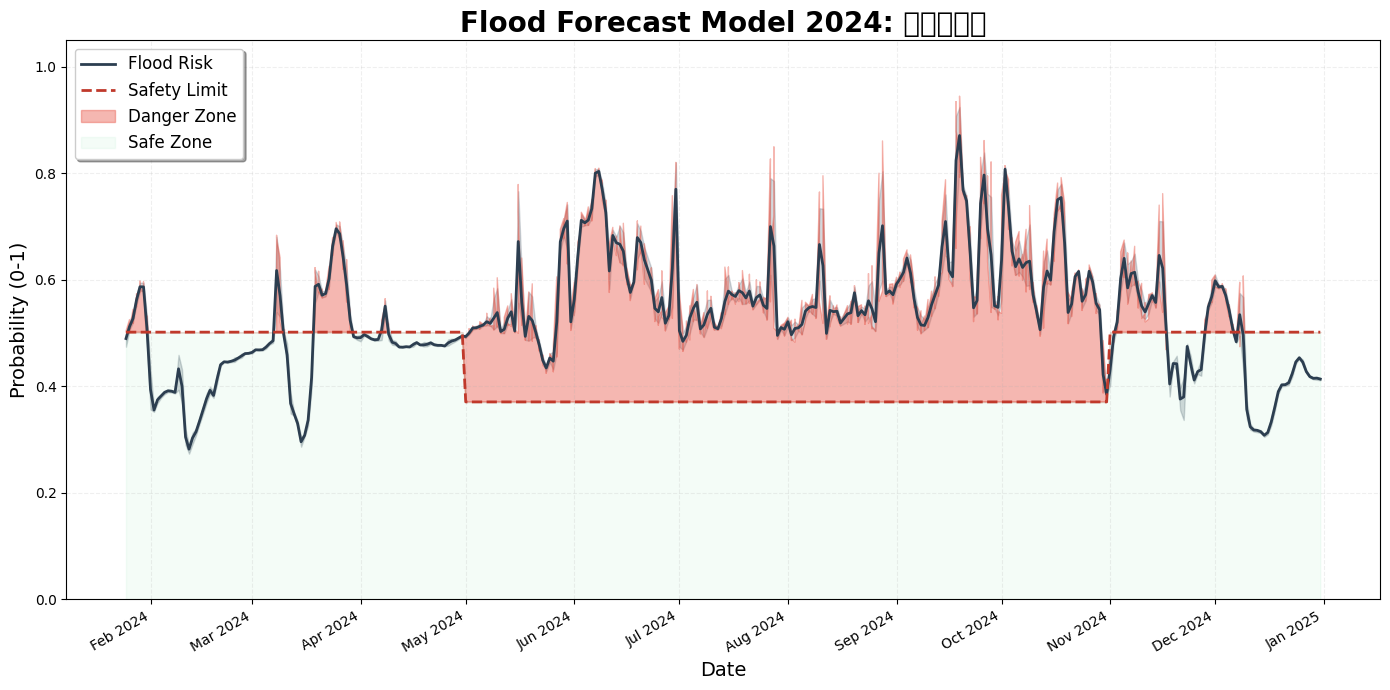

✅ Clean Zone-Chart Generated.


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import os

# --- 1. SYSTEM SETUP ---
if not os.path.exists('/usr/share/fonts/truetype/thai-tlwg/Waree.ttf'):
    print(">>> 🛠️ Installing Thai Fonts...")
    os.system("apt-get install -y fonts-thai-tlwg > /dev/null 2>&1")

# Configure Fonts
preferred_fonts = ['TH Sarabun New', 'Waree', 'Loma', 'Garuda']
for font_name in preferred_fonts:
    found = False
    for d in ['/usr/share/fonts/truetype/thai-tlwg', '.']:
        path = os.path.join(d, f"{font_name}.ttf")
        if os.path.exists(path):
            fm.fontManager.addfont(path)
            plt.rcParams['font.family'] = font_name
            print(f">>> ✅ Loaded Font: {font_name}")
            found = True
            break
    if found: break

# --- 2. DATA PROCESSING ---
csv_path = "/content/2024_forecast.csv" # Check your path
if not os.path.exists(csv_path):
    print("⚠️ Data file not found.")
else:
    df = pd.read_csv(csv_path)

    col_date = 'prediction_date' if 'prediction_date' in df.columns else 'date'
    df['date'] = pd.to_datetime(df[col_date])
    df = df.sort_values('date')

    # Process Risk & Threshold
    col_risk = 'risk_probability' if 'risk_probability' in df.columns else 'risk_score'
    if df[col_risk].dtype == 'object':
        df['risk_numeric'] = df[col_risk].str.rstrip('%').astype(float) / 100.0
    else:
        df['risk_numeric'] = df[col_risk]

    col_thresh = 'threshold' if 'threshold' in df.columns else 'threshold_used'
    if col_thresh in df.columns:
        df['threshold_numeric'] = df[col_thresh].astype(float)
    else:
        df['threshold_numeric'] = 0.4063

    sample_location = df['location'].unique()[0]
    df_plot = df[df['location'] == sample_location].copy()

    # --- 3. SENIOR PLOTTING (ZONE ONLY) ---
    fig, ax = plt.subplots(figsize=(14, 7))

    # A. The Main Trend (Dark Blue Line)
    sns.lineplot(
        data=df_plot,
        x='date',
        y='risk_numeric',
        label='Flood Risk',
        color='#2c3e50',
        linewidth=2, # Slightly thicker to stand out
        ax=ax
    )

    # B. The Threshold (Dashed Red Line)
    sns.lineplot(
        data=df_plot,
        x='date',
        y='threshold_numeric',
        label='Safety Limit',
        color='#c0392b',
        linestyle='--',
        linewidth=2,
        ax=ax
    )

    # C. THE FIX: Zone Only (No Scatter)
    # We highlight the periods where risk exceeds threshold
    ax.fill_between(
        df_plot['date'],
        df_plot['risk_numeric'],
        df_plot['threshold_numeric'],
        where=(df_plot['risk_numeric'] > df_plot['threshold_numeric']),
        interpolate=True,
        color='#e74c3c', # Alert Red
        alpha=0.4,       # Transparency
        label='Danger Zone'
    )

    # D. Safe Zone (Optional Visual Candy)
    # Colors the area below threshold green to signify safety
    ax.fill_between(
        df_plot['date'],
        0,
        df_plot['threshold_numeric'],
        color='#2ecc71', # Emerald Green
        alpha=0.05,      # Very faint
        label='Safe Zone' # Optional legend item
    )

    # Formatting
    ax.set_title(f'Flood Forecast Model 2024: {sample_location}', fontsize=20, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Probability (0-1)', fontsize=14)
    ax.set_ylim(0, 1.05)

    # Clean Date Axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    ax.grid(True, alpha=0.2, linestyle='--')

    # Fancy Legend
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=12)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    print("✅ Clean Zone-Chart Generated.")